In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator as IDG
import matplotlib.pyplot as plt
import datetime
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras import regularizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
images = np.load("/content/drive/MyDrive/IA/greyscale_images_as_numpy_array.npy")
labels = np.loadtxt("/content/drive/MyDrive/IA/train_labels.txt", skiprows=1, usecols=1, delimiter=",", dtype=int)
validation_labels = np.loadtxt("/content/drive/MyDrive/IA/validation_labels.txt", skiprows=1, usecols=1, delimiter=',', dtype=int)

In [8]:
print(np.shape(labels))

(15000,)


In [9]:
GLOBAL_BATCH_SIZE = 64
# labels = np.eye(2)[labels].astype(int)
train_dataset =  tf.data.Dataset.from_tensor_slices((images[:15000].reshape(15000, 224, 224,1), labels))
train_dataset = train_dataset.shuffle(15000).batch(GLOBAL_BATCH_SIZE)
print(train_dataset)

validation_dataset =  tf.data.Dataset.from_tensor_slices((images[15000:17000].reshape(2000, 224, 224,1), validation_labels))
validation_dataset = validation_dataset.batch(GLOBAL_BATCH_SIZE)

print(np.shape(images[17000:]))
test_dataset =  tf.data.Dataset.from_tensor_slices(images[17000:].reshape(np.shape(images[17000:])[0], 224,224,1))
test_dataset = test_dataset.batch(GLOBAL_BATCH_SIZE)                                           

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
(5149, 224, 224)


In [76]:
def building_block(input_tensor, filters, kernel_size, strides):
  x = Conv2D(filters, kernel_size, strides=strides, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_tensor)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters, kernel_size, strides=1, padding='same',  kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  shortcut = Conv2D(filters, kernel_size=1, strides=strides, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_tensor)
  shortcut = BatchNormalization()(shortcut)

  x = Add()([x, shortcut])
  x = Activation('relu')(x)
  return x

In [77]:
def create_model(input_shape):
  input_tensor = Input(shape=input_shape)
  x = RandomRotation(0.25)(input_tensor)
  x = RandomFlip()(input_tensor)
  x = RandomZoom(0.2)(input_tensor)
  x = Normalization()(input_tensor)
  x = Conv2D(64, 4, strides=2, padding='same')(input_tensor)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)

  x = building_block(x, 64, 3, 1)
  x = building_block(x, 64, 3, 1)
  # x = building_block(x, 64, 3, 1)
  # x = building_block(x, 64, 3, 1)

  x = building_block(x, 128, 3, 2)
  x = building_block(x, 128, 3, 1)
  # x = building_block(x, 128, 3, 1)
  # x = building_block(x, 128, 3, 1)
  # x = building_block(x, 128, 3, 1)

  x = building_block(x, 256, 3, 2)
  x = building_block(x, 256, 3, 1)
  # x = building_block(x, 256, 3, 1)
  # x = building_block(x, 256, 3, 1)
  # x = building_block(x, 256, 3, 1)

  x = building_block(x, 512, 3, 2)
  # x = building_block(x, 512, 3, 1)
  # x = building_block(x, 512, 3, 1)
  # x = building_block(x, 512, 3, 1)


  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation = 'relu')(x)
  x = Dense(512, activation = 'relu')(x)
  # x = Dense(512, activation = 'relu')(x)
  # x = Dense(512, activation = 'relu')(x)
  x = Dropout(0.33)(x)

  x = Dense(1, activation='sigmoid')(x)
  model = Model(input_tensor, x)
  
  return model



In [99]:
def create_model(input_shape):
  input_tensor = Input(shape=input_shape)
  x = RandomRotation(0.25)(input_tensor)
  x = RandomFlip()(input_tensor)
  x = RandomZoom(0.2)(input_tensor)

  x = Conv2D(64, 7, strides=2, padding='same')(input_tensor)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(3, strides=2, padding='same')(x)

  x = building_block(x, 64, 3, 1)
  x = building_block(x, 64, 3, 1)
  x = building_block(x, 64, 3, 1)
  x = building_block(x, 64, 3, 1)


  x = building_block(x, 128, 3, 2)
  x = building_block(x, 128, 3, 1)
  x = building_block(x, 128, 3, 1)
  x = building_block(x, 128, 3, 1)
  x = building_block(x, 128, 3, 1)


  x = building_block(x, 256, 3, 2)
  x = building_block(x, 256, 3, 1)
  x = building_block(x, 256, 3, 1)
  x = building_block(x, 256, 3, 1)
  x = building_block(x, 256, 3, 1)
  x = building_block(x, 256, 3, 1)


  # x = building_block(x, 512, 3, 2)
  # x = building_block(x, 512, 3, 1)


  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation = 'relu')(x)
  x = Dense(512, activation = 'relu')(x)
  x = Dropout(0.33)(x)
  x = Dense(1, activation='sigmoid')(x)
  
  model = Model(input_tensor, x)
  
  return model



In [100]:
from sklearn.metrics import f1_score
def f1(labels, predictii):
    predictii = tf.round(predictii)
    return tf.py_function(f1_score, (labels, predictii), tf.float64)

optimizer = optimizers.Adam(learning_rate=0.0001)
model = create_model((224, 224, 1))
model.compile(optimizer=optimizer, loss='BinaryCrossentropy', metrics=['accuracy', f1, 'Precision', 'Recall'])
model.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_468 (Conv2D)            (None, 112, 112, 64  3200        ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_468 (Batch  (None, 112, 112, 64  256        ['conv2d_468[0][0]']             
 Normalization)                 )                                                          

In [101]:
def lr_schedule(epoch):
    lr = 0.001
    if epoch >= 5:
        lr *= 0.1
    if epoch >= 15:
        lr *= 0.1
    if epoch >= 40:
        lr *= 0.1
    return lr


In [ ]:

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
checkpoint_path = "training_1/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor= 'val_f1',
                                                 save_best_only = True,
                                                 mode = 'max',
                                                 verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks = [callback, cp_callback, lr_scheduler])




Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 2.1319 - accuracy: 0.8553 - f1: 0.2406 - precision: 0.5456 - recall: 0.1819
Epoch 1: val_f1 improved from -inf to 0.01406, saving model to training_1/cp.ckpt
235/235 [==============================] - 98s 392ms/step - loss: 2.1319 - accuracy: 0.8553 - f1: 0.2406 - precision: 0.5456 - recall: 0.1819 - val_loss: 0.7082 - val_accuracy: 0.8625 - val_f1: 0.0141 - val_precision: 0.6667 - val_recall: 0.0072 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - ETA: 0s - loss: 0.5132 - accuracy: 0.8713 - f1: 0.4458 - precision: 0.6107 - recall: 0.3785
Epoch 2: val_f1 did not improve from 0.01406
235/235 [==============================] - 89s 378ms/step - loss: 0.5132 - accuracy: 0.8713 - f1: 0.4458 - precision: 0.6107 - recall: 0.3785 - val_loss: 1.0496 - val_accuracy: 0.8620 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/50
235/235 [==============================]

In [1]:
pred_val1 = model.predict(images[15000:17000])
print(max(pred_val1))
print(min(pred_val1))
import sklearn, sklearn.metrics
cel_mai_bun_i = -1
cel_mai_bun_f1 = -1
for i in  np.arange(0.000, 1.000, 0.001):
    pred_val_labels = (pred_val1 > i).astype(int)
    f1 = sklearn.metrics.f1_score(validation_labels, pred_val_labels)
    if(f1 >= cel_mai_bun_f1):
        cel_mai_bun_f1 = f1
        cel_mai_bun_i = i
#         print(np.sum(pred_val_labels == 1))
print(cel_mai_bun_i)
print(f"f1 score: {cel_mai_bun_f1}")

NameError: ignored

In [97]:
model.load_weights('training_1/cp.ckpt')


In [93]:
pred_data_test = model.predict(images[17000:])
print(cel_mai_bun_i)
pred_data_test_labels = (pred_data_test > cel_mai_bun_i).astype(int)
print(np.sum(pred_data_test_labels == 1))
import csv
with open("predictionCnn92_tensorflow_0.619.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "class"])
    for i in range(17000, len(images)):
        writer.writerow(['0' + str(i+1), int(pred_data_test_labels[i - 17000])])

161/161 [==============================] - 7s 41ms/step
0.446
720


32/32 [==============================] - 3s 86ms/step - loss: 0.2685 - accuracy: 0.8975 - f1: 0.5984 - precision: 0.6437 - recall: 0.5761
[[1724    0]
 [ 276    0]]


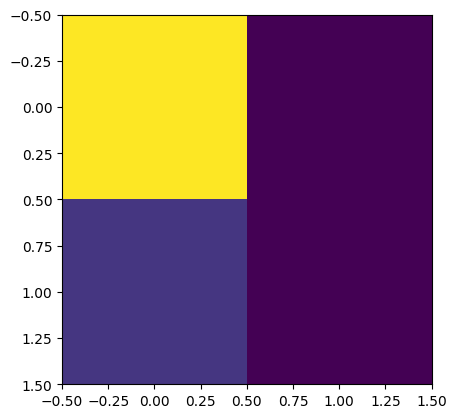

In [94]:
from sklearn.metrics import confusion_matrix
model.evaluate(validation_dataset)
# confusion_prob = model.predict(images[17000])
# confusion_labels = np.argmax(confusion_prob, axis=1)
cm = confusion_matrix(validation_labels, pred_val_labels)
print(cm)
np.savetxt('cm_test', cm)
plt.imshow(cm)
plt.savefig('cm')

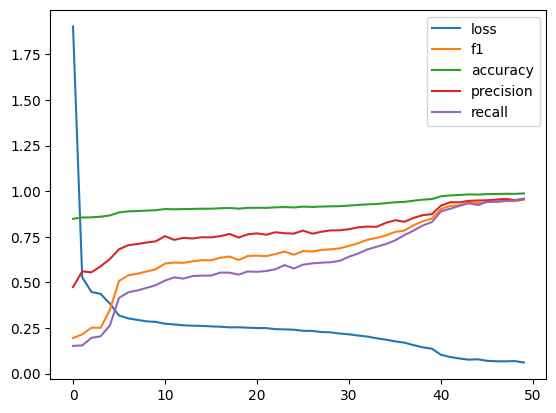

In [95]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['f1'], label='f1')
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.plot(history.history['precision'], label='precisio')
plt.plot(history.history['recall'], label='recall')

plt.legend(['loss', 'f1', 'accuracy', 'precision', 'recall'])
plt.savefig("history")

In [22]:
plt.plot(history.history['f1'], label = 'f1')
plt.plot(history.history['val_f1'], label = 'val_f1')
plt.legend(['f1_train','f1_validare'])
plt.savefig("diferenta train-validare")

NameError: ignored

In [25]:
history

import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator as IDG
import matplotlib.pyplot as plt
import datetime
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras import regularizers
from google.colab import drive
drive.mount('/content/drive')
images = np.load("/content/drive/MyDrive/IA/greyscale_images_as_numpy_array.npy")
labels = np.loadtxt("/content/drive/MyDrive/IA/train_labels.txt", skiprows=1, usecols=1, delimiter=",", dtype=int)
validation_labels = np.loadtxt("/content/drive/MyDrive/IA/validation_labels.txt", skiprows=1, usecols=1, delimiter=',', dtype=int)
GLOBAL_BATCH_SIZE = 64
# labels = np.eye(2)[labels].astype(int)
train_dataset =  tf.data.Dataset.from_tensor_slices((images[:15000].reshape(15000, 224, 224,1), labels))
train_dataset = train_dataset.shuff